# Loading the preprocessed data

In [ ]:
import os
from pathlib import Path
import pandas as pd

DirPpath = Path(os.path.abspath('')).parent # Fetching the current directory path - Specific for ipynb file - For .py: Path(os.path.dirname(os.path.realpath(__file__)).replace("\\", "/"))


LDAPath  = str(DirPpath.absolute()) + "\PreProcessedData.csv"  
Lda = pd.read_csv(LDAPath, index_col=0)

Lda.head()

# Finding Optimal number of topics

In [2]:
import nltk
# LDA has to be applied on tokenized vectors
tokens = [nltk.word_tokenize(i) for i in Lda["PreProcessedText"]]

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(tokens)
# Create Corpus
texts = tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 5), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


In [5]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

LDA = gensim.models.ldamodel.LdaModel

results = []

for t in range(2, 30):
    lda_model = LDA(corpus=corpus, id2word=id2word, num_topics=t, random_state=100,
                chunksize=200, passes=100)
    corpus_lda = lda_model[corpus]

    cm = CoherenceModel( model=lda_model,texts=tokens, dictionary=id2word, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])


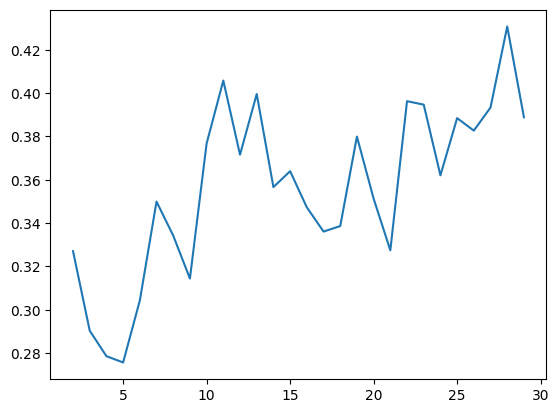

In [6]:
s = pd.Series(results.score.values, index=results.topic.values)
_ = s.plot()

# Building model (26 topics)

In [ ]:
import gensim
from pprint import pprint
# number of topics
num_topics = 26
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=Lda["PreProcessedText"]):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

df_dominant_topic["Topic"] = Lda["Topic"]


Path = str(DirPpath.absolute()) + "\LDATopics.xlsx"
df_dominant_topic.to_excel(Path)

<>:36: DeprecationWarning: invalid escape sequence \L
<>:36: DeprecationWarning: invalid escape sequence \L
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_18708\3614537058.py:36: DeprecationWarning: invalid escape sequence \L
  Path = str(DirPpath.absolute()) + "\LDATopics.xlsx"
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_18708\3614537058.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_18708\3614537058.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_1

# Visualizing the topics

In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(topic_model = lda_model, corpus = corpus, dictionary = id2word) # mds = 'tsne'
panel